In [1]:
from shapes_dataset_generator import ShapesDatasetGenerator
from dataset import ShapesDataModule
import numpy as np
import torch
import matplotlib.pyplot as plt
from models import VanillaVAE

In [9]:
sdg = ShapesDatasetGenerator(random_seed=42, render_config={"anti_alias": 1, "canvas_size" : 32})
m, l = sdg.generate(10000)
m.shape

(10000, 32, 32, 3)

In [10]:
np.save("/cs/labs/yweiss/adirt/lab_project/vae-lab-project/data/shapes_32x32_10000.npy", m)

In [5]:
import os
np.load("data/shapes_32x32_10000.npy")

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [43]:
np.save('shapes_32x32_10000.npy', dataset)

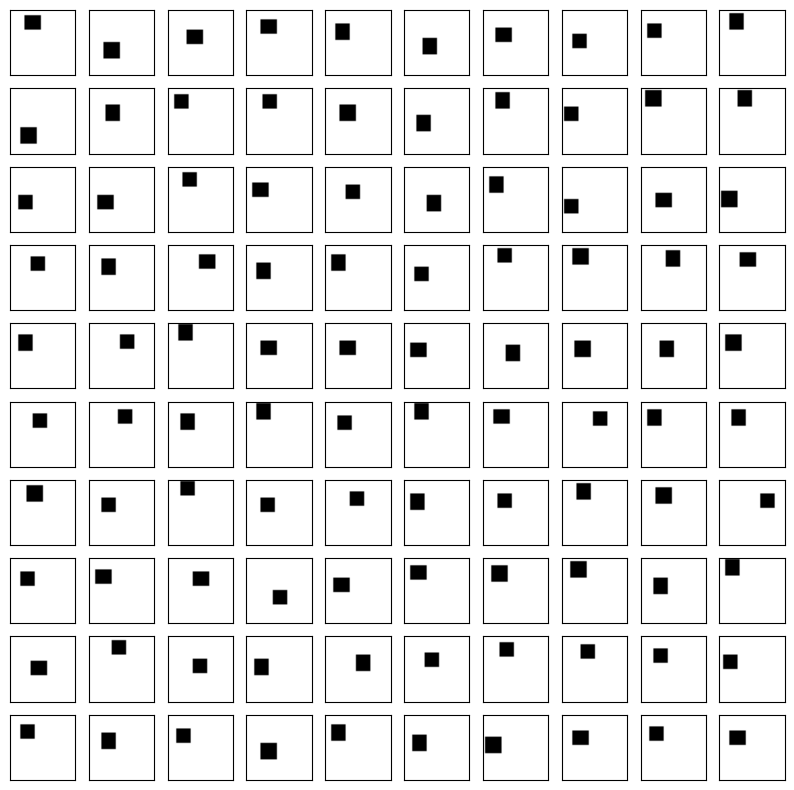

In [11]:
# Define the grid size
grid_size = 10

# Create a figure and axis
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Iterate through the images and plot them
for i, ax in enumerate(axes.flat):
    # If there are fewer images than grid cells, hide the remaining empty plots
    if i < m.shape[0]:
        ax.imshow(m[i])
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')
        ax.set_visible(False)

plt.show()

In [3]:
npx = np.random.rand(2, 3, 32, 32).astype(np.float32)
x = torch.Tensor(npx)
j = model(x)


In [15]:
# j[0][0].detach().numpy().transpose(1, 2, 0)
plt.imshow(j[0][0].detach().numpy().transpose(1, 2, 0))

array([[[-0.21055928,  0.04126837,  0.13222559],
        [-0.24939789, -0.14848007, -0.10389824],
        [-0.46378392, -0.2724796 ,  0.28930557],
        ...,
        [ 0.01129521, -0.06534824, -0.0836994 ],
        [ 0.10690145, -0.12390669,  0.23714538],
        [ 0.08895503, -0.0445008 , -0.0525538 ]],

       [[-0.22361828,  0.23042154,  0.13246098],
        [-0.2759644 ,  0.3332795 , -0.06351516],
        [-0.45264253,  0.74151886, -0.36202615],
        ...,
        [-0.05208807,  0.14300722, -0.23552863],
        [-0.10298625,  0.09435927, -0.14895596],
        [-0.05585251, -0.11756548, -0.11724118]],

       [[-0.34662598,  0.06921551, -0.00556397],
        [ 0.1007173 ,  0.05595879,  0.38143772],
        [ 0.11756782,  0.8814636 , -0.17857897],
        ...,
        [-0.02090594, -0.08075953,  0.18209253],
        [-0.22592387,  0.1109147 ,  0.29263172],
        [-0.12955087,  0.10874332, -0.06551334]],

       ...,

       [[-0.22262889,  0.08635124,  0.07197537],
        [-0